# Analyzing the Spectrum of Explainability in Outcome-Oriented Predictive Process Monitoring

## BPIC2017_Accepted

### data preprocessing

#### importing libraries and terminology

In [1]:
#import libraries

In [2]:
import pandas as pd
from pandas import Series
import numpy as np
import time
import random
import pickle

from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OrdinalEncoder

#user specified packages from Teinemaa
import EncoderFactory
from DatasetManager import DatasetManager



#visualisation packages
import graphviz
from sklearn import tree
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *

#import shap
import shap

#models
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#IBM package models
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import LogisticRuleRegression

#LSTM
import logging
from collections import OrderedDict
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, GRU, Dropout, Input, Reshape, Activation, Multiply, TimeDistributed, concatenate, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\ten

In [3]:
#terminology

In [4]:
params_dir = './params_dir'
results_dir = './results' 
DT_dir = './DT_dir'
cls_encoding = 'agg'

gap = 1
n_iter = 1

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

train_ratio = 0.8
random_state = 22

In [5]:
dataset_ref = 'bpic2017_accepted'
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]

In [6]:
# print dataset name

In [7]:
for dataset_name in datasets:
    print('Dataset:', dataset_name)

Dataset: bpic2017_accepted


In [8]:
# read the data

In [9]:
dataset_manager = DatasetManager(dataset_name)
data = dataset_manager.read_dataset()
cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

In [10]:
# determine min and max (truncated) prefix lengths

In [11]:
min_prefix_length = 1
if "traffic_fines" in dataset_name:
    max_prefix_length = 10
elif "bpic2017" in dataset_name:
    max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
else:
    max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

#### EDA

In [12]:
#data types

In [13]:
data.dtypes

ApplicationType                  object
LoanGoal                         object
RequestedAmount                 float64
Case ID                          object
label                            object
Activity                         object
org:resource                     object
Action                           object
EventOrigin                      object
lifecycle:transition             object
Accepted                         object
Selected                         object
FirstWithdrawalAmount           float64
MonthlyCost                     float64
NumberOfTerms                   float64
OfferedAmount                   float64
CreditScore                     float64
timesincelastevent              float64
timesincecasestart              float64
timesincemidnight               float64
event_nr                        float64
month                           float64
weekday                         float64
hour                            float64
open_cases                      float64


In [14]:
#dimensions

In [15]:
print(data.shape[0],',', data.shape[1])

1198366 , 26


In [16]:
#print first 5 rows of the data

In [17]:
data.head()

,ApplicationType,LoanGoal,RequestedAmount,Case ID,label,Activity,org:resource,Action,EventOrigin,lifecycle:transition,...,CreditScore,timesincelastevent,timesincecasestart,timesincemidnight,event_nr,month,weekday,hour,open_cases,time:timestamp
0,New credit,Existing loan takeover,20000.0,Application_652823628,deviant,A_Create Application,User_1,Created,Application,complete,...,0.0,0.000000,0.000000,591.0,1.0,1.0,4.0,9.0,0.0,2016-01-01 09:51:15.304
1,New credit,Existing loan takeover,20000.0,Application_652823628,deviant,A_Submitted,User_1,statechange,Application,complete,...,0.0,0.000800,0.000800,591.0,2.0,1.0,4.0,9.0,1.0,2016-01-01 09:51:15.352
2,New credit,Existing loan takeover,20000.0,Application_652823628,deviant,W_Handle leads,User_1,Created,Workflow,schedule,...,0.0,0.007033,0.007833,591.0,3.0,1.0,4.0,9.0,1.0,2016-01-01 09:51:15.774
3,New credit,Existing loan takeover,20000.0,Application_652823628,deviant,W_Handle leads,User_1,Deleted,Workflow,withdraw,...,0.0,1.343633,1.351467,592.0,4.0,1.0,4.0,9.0,1.0,2016-01-01 09:52:36.392
4,New credit,Existing loan takeover,20000.0,Application_652823628,deviant,W_Complete application,User_1,Created,Workflow,schedule,...,0.0,0.000183,1.351650,592.0,5.0,1.0,4.0,9.0,1.0,2016-01-01 09:52:36.403


In [18]:
import pylab as pl

In [19]:
#histogram of the event numbers

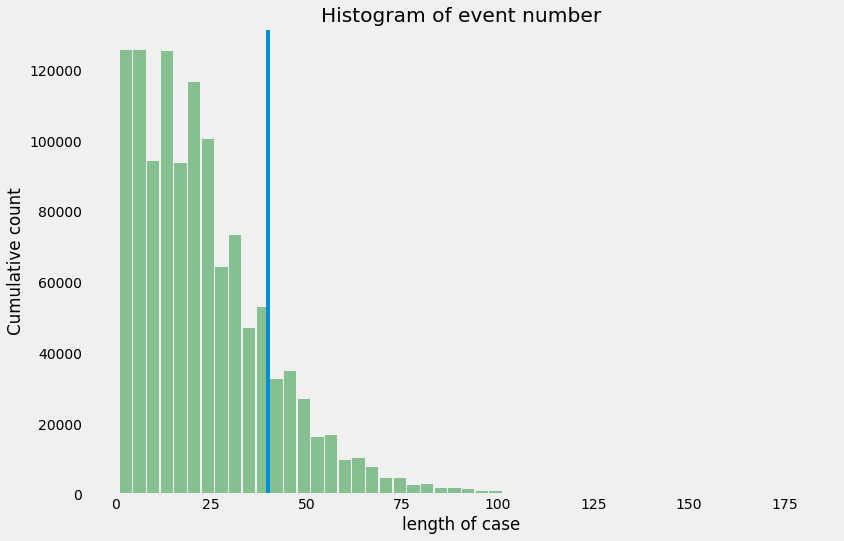

In [20]:
histo = data.hist(column='event_nr',bins=50, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
pl.title("Histogram of event number")
pl.xlabel("length of case")
pl.ylabel("Cumulative count")
plt.axvline(x=40, ymin=0, ymax=1)

In [21]:
#maximal length of an event

In [22]:
max_event = data['event_nr'].max()
max_event

180.0

#### data preprocessing

In [23]:
# split into training and test
train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

In [24]:
#prefix generation of train and test data

In [25]:
print('prefixing started')
dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

prefixing started


In [26]:
dt_train_prefixes_original = dt_train_prefixes.copy()
dt_test_prefixes_original = dt_test_prefixes.copy()

In [27]:
#get the label of the train and test set
test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   

In [28]:
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
offline_total_times = []
online_event_times = []

In [29]:
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))  
test_y_all.extend(test_y)

#### feature combiner and columns

In [60]:
feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])
feature_combiner.fit(dt_train_prefixes, train_y)
    
dt_train_named = feature_combiner.transform(dt_train_prefixes)
dt_train_named = pd.DataFrame(dt_train_named)
names= feature_combiner.get_feature_names()
dt_train_named.columns = names

In [61]:
#transform test dataset
dt_test_named = feature_combiner.transform(dt_test_prefixes)
dt_test_named = pd.DataFrame(dt_test_named)
names= feature_combiner.get_feature_names()
dt_test_named.columns = names

In [62]:
dt_train_named_original = dt_train_named.copy()
dt_test_named_original = dt_test_named.copy()

In [63]:
dt_train_named = dt_train_named_original.copy()
dt_test_named = dt_test_named_original.copy()

#### feature selection columns

aggregation columns

In [34]:
#all columns
columns_all = list(dt_train_named.columns)

In [35]:
#20% PC

In [36]:
columns_PC20= ['agg__CreditScore_std', 'agg__Selected_False']

In [37]:
#15% PC

In [38]:
columns_PC15= ['agg__CreditScore_std',
 'agg__Selected_False',
 'static__ApplicationType_New credit',
 'static__ApplicationType_Limit raise']

In [39]:
#10% PC

In [40]:
columns_PC10 = ['static__ApplicationType_Limit raise',
 'static__ApplicationType_New credit',
 'agg__Activity_A_Cancelled',
 'agg__Activity_A_Submitted',
 'agg__Activity_W_Validate application',
 'agg__lifecycle:transition_ate_abort',
 'agg__Accepted_False',
 'agg__Accepted_True',
 'agg__Selected_False',
 'agg__CreditScore_std']

#### values to change

In [64]:
#############################
#######VALUES TO CHANGE######
#############################

In [65]:
columns = columns_PC10

In [66]:
print(columns)

['static__ApplicationType_Limit raise', 'static__ApplicationType_New credit', 'agg__Activity_A_Cancelled', 'agg__Activity_A_Submitted', 'agg__Activity_W_Validate application', 'agg__lifecycle:transition_ate_abort', 'agg__Accepted_False', 'agg__Accepted_True', 'agg__Selected_False', 'agg__CreditScore_std']


In [67]:
column_selection = 'PC10'

In [68]:
cls_method ='glrm'
method_name = "%s_%s"%(column_selection, cls_encoding)

In [69]:
#method_name

In [70]:
method_name

'PC10_agg'

In [71]:
cls_method

'glrm'

In [72]:
# load optimal params

In [73]:
optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
    print('problem')

with open(optimal_params_filename, "rb") as fin:
    args = pickle.load(fin)
    print(args)

{'lambda0': 0.002506433922159593, 'lambda1': 0.002304030840029294}


In [74]:
dt_train_named.dtypes

static__RequestedAmount                float64
static__ApplicationType_Limit raise    float64
static__ApplicationType_New credit     float64
static__LoanGoal_Car                   float64
static__LoanGoal_Caravan / Camper      float64
                                        ...   
agg__open_cases_max                    float64
agg__open_cases_mean                   float64
agg__open_cases_min                    float64
agg__open_cases_std                    float64
agg__open_cases_sum                    float64
Length: 259, dtype: object

In [75]:
dt_train_named = dt_train_named[columns]
dt_test_named = dt_test_named[columns]
len(dt_train_named.dtypes)

10

In [76]:
print(dt_train_named.columns)

Index(['static__ApplicationType_Limit raise',
       'static__ApplicationType_New credit', 'agg__Activity_A_Cancelled',
       'agg__Activity_A_Submitted', 'agg__Activity_W_Validate application',
       'agg__lifecycle:transition_ate_abort', 'agg__Accepted_False',
       'agg__Accepted_True', 'agg__Selected_False', 'agg__CreditScore_std'],
      dtype='object')


In [77]:
if gap > 1:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
else:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [78]:
outfile

'./results\\performance_results_glrm_bpic2017_accepted_PC10_agg.csv'

### LLM

#### model

In [86]:
current_args = args 

In [93]:
cls_dt = tree.DecisionTreeClassifier(criterion= 'entropy', 
                                 max_depth= args['max_depth'], 
                                 min_samples_leaf= args['min_samples_leaf'], 
                                 random_state = random_state)
cls_dt.fit(dt_train_named,train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=190,
                       random_state=22)

label
deviant    AxesSubplot(0.08,0.07;0.87x0.81)
regular    AxesSubplot(0.08,0.07;0.87x0.81)
Name: CreditScore, dtype: object

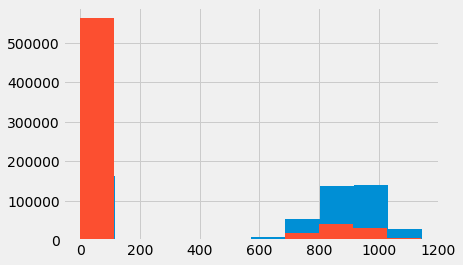

In [94]:
data.groupby(['label'])['CreditScore'].hist()

In [95]:
data.groupby(['label'])['CreditScore'].std()

label
deviant    421.441698
regular    319.245790
Name: CreditScore, dtype: float64

In [ ]:
viz = dtreeviz(cls, 
               dt_train_named, 
               np.array(train_y),
               target_name='label',
               feature_names=dt_train_named.columns, 
               class_names=["deviant",'regular'],
               label_fontsize=5, ticks_fontsize=5# need class_names for classifier
              )  
              
viz.view() 

In [96]:
#cluster numbers
print(set(cls.apply(dt_train_named)))

{2, 3, 5, 6}


In [97]:
#add an extra column with the number of the leave node
#these can be seen as the homogeneuous segments (buckets)
dt_train_named['cluster'] = cls_dt.apply(dt_train_named)
dt_test_named['cluster'] = cls_dt.apply(dt_test_named)
cluster_number = list(dt_test_named['cluster'])
train_y_concat = pd.DataFrame(train_y)
train_y_concat = train_y_concat.rename(columns={train_y_concat.columns[0]:'label'})
dt_train_named = pd.concat([dt_train_named,train_y_concat], axis=1)
test_y_concat  = pd.DataFrame(test_y)
test_y_concat  = test_y_concat.rename(columns={test_y_concat.columns[0]:'label'})
dt_test_named = pd.concat([dt_test_named, test_y_concat], axis=1)

In [98]:
#list of leaves that contain test data 
leaves = list((dt_test_named['cluster'].unique()))
a = np.array(cluster_number)
b = np.array(nr_events_all)

#reorder the event numbers
event_list = []
for i in leaves:
    event_list.extend(b[a==i].tolist())

In [99]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
print('model after DT started')
avg_runtime = []
start = time.time()
for i in leaves:  
    #only take the data from the leave, seperate the label from the independent features
    data_train_x = dt_train_named[dt_train_named['cluster']==i].copy()
    data_train_y = data_train_x['label'].copy()
    
    data_test_x  = dt_test_named[dt_test_named['cluster']==i].copy()
    data_test_y  = data_test_x['label'].copy()
        
    #drop the columns
    data_train_x = data_train_x.drop('label', axis=1)
    data_train_x = data_train_x.drop('cluster', axis=1)
    data_test_x = data_test_x.drop('label', axis=1)
    data_test_x = data_test_x.drop('cluster', axis=1)
        
    
    #if there is only one label in the training data, no need to create a leaf model
    if len(set(data_train_y))<2:
        pred = [data_train_y.iloc[0]]*len(data_test_y)
        preds_all.extend(pred)
        test_y_all.extend(data_test_y)
        classifiers.append('only one training label')
        try:
            auc = roc_auc_score(data_test_y,preds)
            aucs.append(auc)
        except:
            #perfect classifcation so an AUC of 1
            auc=1
            aucs.append(auc)
                
    else:  
        #print length of test and training data of the leaf node
        l = [["length test data", len(data_test_x)], ["length training data", len(data_train_x)]]
        table = tabulate(l, tablefmt='orgtbl')
        print(table)
        test_y_all.extend(data_test_y)
            
        if cls_method == 'llm':
                scaler = StandardScaler()
                data_train_x2= scaler.fit_transform(data_train_x)
                data_test_x2= scaler.transform(data_test_x)
                data_train_x = pd.DataFrame(data_train_x2, columns = data_train_x.columns)
                data_test_x = pd.DataFrame(data_test_x2, columns = data_test_x.columns)
                preds_pos_label_idx = np.where(cls_dt.classes_ == 1)[0][0]
                logreg = LogisticRegression(max_iter= 10000000, 
                                            penalty= 'l1', solver='saga')     
                logreg.fit(data_train_x, data_train_y)
                
                pred = logreg.predict_proba(data_test_x)
                pred = pred[:,preds_pos_label_idx]
                logmodel=pd.DataFrame({'odds_ratio':(np.exp(logreg.coef_).T).tolist(),'variable':data_train_x.columns.tolist()})
                logmodel['odds_ratio'] = logmodel['odds_ratio'].str.get(0)
                logmodel=logmodel.sort_values('odds_ratio', ascending=False)
                #logs
                coefs = {"coef": ["coef_%s"%i]}
                coef = coefs['coef'][0]
                coefhelp = logmodel
                exec(coef + "=coefhelp")
                #coefficients
                orig_coefs = {"orig_coef": ["orig_coef_%s"%i]}
                orig_coef = orig_coefs['orig_coef'][0]
                orig_coefhelp = logreg.coef_
                exec(orig_coef + "=orig_coefhelp")
                        
                #this seperation is solely to be able to calculate the AUC for every leaf node model
                if len(set(data_test_y))>1:
                    auc = roc_auc_score(data_test_y, pred)
                    print(auc)
                    aucs.append(auc)
                    preds_all.extend(pred)
                    classifiers.append('leaf model')                    
                            
                elif len(set(data_test_y))==1:
                    auc = 1
                    aucs.append(auc)
                    preds_all.extend(pred)
                    classifiers.append('leaf model')
                    
total_time = time.time() - start
avg_runtime.append(total_time/ (len(dt_train_named)+len(dt_test_named)))

auc_total = roc_auc_score(test_y_all, preds_all)
    
    

print("results are up")        

model after DT started
| length test data     |  66589 |
| length training data | 268133 |
0.6674368507355385
| length test data     | 24991 |
| length training data | 98415 |
0.6604550843430254
| length test data     |  29885 |
| length training data | 116193 |
0.6221536266586901
| length test data     |  3350 |
| length training data | 12151 |
0.5834625490972104
results are up


In [100]:
cf = []
for i in leaves:
    coefficients = "coef_%s"%i
    cf.append(coefficients)

In [101]:
cf

['coef_2', 'coef_5', 'coef_3', 'coef_6']

In [102]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": event_list})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(aucs))
        fout.write("%s;%s;%s;%s\n"%(coef_2, coef_5, coef_3, coef_6))

In [103]:
auc_total

0.8813999562884116

In [104]:
coef_2 = coef_2.sort_values(by='variable')
coef_2

,odds_ratio,variable
6,0.595145,agg__Accepted_False
7,0.809966,agg__Accepted_True
2,0.986985,agg__Activity_A_Cancelled
3,0.882278,agg__Activity_A_Submitted
4,1.120574,agg__Activity_W_Validate application
9,1.228663,agg__CreditScore_std
8,1.000000,agg__Selected_False
5,1.096723,agg__lifecycle:transition_ate_abort
0,1.435434,static__ApplicationType_Limit raise
1,0.696654,static__ApplicationType_New credit


In [105]:
coef = list(coef_2['odds_ratio'])
for i in coef:
    print(round(i,4))

0.5951
0.81
0.987
0.8823
1.1206
1.2287
1.0
1.0967
1.4354
0.6967


In [106]:
coef_5 = coef_5.sort_values(by='variable')
coef = list(coef_5['odds_ratio'])
for i in coef:
    print(round(i,4))

1.1252
1.5691
1.0
1.0905
0.9725
1.245
1.0
1.0503
1.1013
0.908


In [107]:
coef_3 = coef_3.sort_values(by='variable')
coef = list(coef_3['odds_ratio'])
for i in coef:
    print(round(i,4))

1.1952
1.363
0.209
0.7482
1.0146
1.1908
0.5859
0.999
1.0379
0.9634


In [108]:
coef_6 = coef_6.sort_values(by='variable')
coef = list(coef_6['odds_ratio'])
for i in coef:
    print(round(i,4))

1.0933
1.1852
1.0
0.7714
0.7703
1.3093
0.8699
1.063
1.0483
0.9539


In [109]:
method_name

'PC10_agg'

In [110]:
auc_total

0.8813999562884116

In [111]:
aucs

[0.6674368507355385,
 0.6604550843430254,
 0.6221536266586901,
 0.5834625490972104]

In [112]:
classifiers

['leaf model', 'leaf model', 'leaf model', 'leaf model']

In [113]:
#textual representation of the DT
text_representation = tree.export_text(cls)
print(text_representation)

|--- feature_9 <= 236.51
|   |--- feature_8 <= 0.50
|   |   |--- class: 0
|   |--- feature_8 >  0.50
|   |   |--- class: 0
|--- feature_9 >  236.51
|   |--- feature_8 <= 0.50
|   |   |--- class: 1
|   |--- feature_8 >  0.50
|   |   |--- class: 0



In [114]:
#define decision rules per leaf node
n_nodes = cls.tree_.node_count
children_left = cls.tree_.children_left
children_right = cls.tree_.children_right
feature = cls.tree_.feature
threshold = cls.tree_.threshold

def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False
def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [115]:
#for all the leave nodes:

# Leave node
leave_id = cls.apply(dt_train_named[columns])
paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))
rules1 = {}
for key in paths:
    rules1[key] = get_rule(paths[key], data_train_x.columns)

rules1

{2: "(df['agg__CreditScore_std']<= 236.50508880615234) & (df['agg__Selected_False']<= 0.5)  ",
 3: "(df['agg__CreditScore_std']<= 236.50508880615234) & (df['agg__Selected_False']> 0.5)  ",
 5: "(df['agg__CreditScore_std']> 236.50508880615234) & (df['agg__Selected_False']<= 0.5)  ",
 6: "(df['agg__CreditScore_std']> 236.50508880615234) & (df['agg__Selected_False']> 0.5)  "}

### GLRM

In [79]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
avg_runtime = []
start = time.time()
len_testdata = len(dt_test_named)
len_traindata = len(dt_train_named)
test_y_all.extend(test_y)
  
    #Featurebinarizer
"We assume that all features Xj have been binarized to take values in {0, 1}. Categorical and numerical features were binarized" 
"using sample deciles as thresholds for numerical features."
                
"For categorical features, this is achieved through the usual “one-hot” coding into indicators Xj = x for all categories"
"x as well as their negations Xj != x  (From GLRM, Dennis Wei)"

"==> The categorical features have already been onehotencoded by Teinemaa. Therefore, the negations will not be added as features."
"This should not cause any problems as one of the parameters of the featurebinarizer allows you to exclude these negations"
        
"Numerical features are binarized through bi-directional comparisons to a set of thresholds, e.g., Xj ≤ 1, Xj ≤ 2.3 and Xj > 1, Xj > 2.3"
"ordinal features can optionally be standardized"
            
"Then what does it do next?"
"Once the column generation algorithm terminates, we solve the log-likelihood problem (4) one last time to de-bias the solution."
"In this final run we restrict conjunctions to the ones with β±k > 10−5 in the last round and we drop the regularization term in the objective."
fb = FeatureBinarizer(negations=False, returnOrd=True, threshStr=False, numThresh=10 )
'threshStr= False :Convert thresholds on ordinal features to strings'
'returnOrd= True: return standardized ordinal features'
'negations= False: do not compute negations of categorical features'
'numTresh: raising this number will improve the performance'
dt_train_named, dfTrainStd = fb.fit_transform(dt_train_named)
dt_test_named, dfTestStd = fb.transform(dt_test_named)
'lambda0 = 0.001  : Regularization - fixed cost of each rule'
'lambda1 = 0.00005: Regularization - additional cost of each literal in rule'
'iterMax= pow(1000,1000): Column generation - maximum number of iterations, intentionally very high numberoes not add much to runtime'           
cls_glrm= LogisticRuleRegression(lambda0=args['lambda0'], lambda1=args['lambda1'], iterMax= 10000)   
    # Train, print, and evaluate model
cls_glrm.fit(dt_train_named, pd.Series(train_y))

                
pred = cls_glrm.predict_proba(dt_test_named)
preds_all.extend(pred)      

total_time = time.time() - start
avg_runtime.append(total_time/ (len_traindata+len_testdata))
auc_total = roc_auc_score(test_y_all, preds_all)
   
print("results are up")

results are up


In [80]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))

In [81]:
total_time

34.45537734031677

In [82]:
auc_total

0.8751971626773752

In [85]:
cls_glrm.explain()

,rule,coefficient
0,(intercept),-0.259226
1,agg__Selected_False <= 0.00,6.57334
2,agg__CreditScore_std <= 0.00,-6.27403
3,agg__Accepted_False <= 0.00 AND agg__Selected_...,2.43235
4,static__ApplicationType_New credit,-1.74508
5,static__ApplicationType_Limit raise,1.61002
6,agg__CreditScore_std <= 360.94,-1.16849
7,agg__Accepted_False <= 0.00,0.510338
8,agg__Activity_A_Submitted,-0.462146


In [87]:
explanations = cls_glrm.explain()

In [88]:
for i in range(0,len(explanations)):
    print(explanations['rule'].iloc[i])

(intercept)
agg__Selected_False <= 0.00
agg__CreditScore_std <= 0.00
agg__Accepted_False <= 0.00 AND agg__Selected_False <= 7.00
static__ApplicationType_New credit  
static__ApplicationType_Limit raise  
agg__CreditScore_std <= 360.94
agg__Accepted_False <= 0.00
agg__Activity_A_Submitted  


In [89]:
for i in range(0,len(explanations)):
    print(round(explanations['coefficient'].iloc[i],2))

-0.26
6.57
-6.27
2.43
-1.75
1.61
-1.17
0.51
-0.46


### XGBoost

###### model

In [294]:
current_args= args

In [295]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
avg_runtime = []
nr_events_all = []
start = time.time()
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))
len_testdata = len(dt_test_named)
len_traindata = len(dt_train_named)
test_y_all.extend(test_y)


cls = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)
    
    
cls.fit(dt_train_named, train_y)
preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
pred = cls.predict_proba(dt_test_named)[:,preds_pos_label_idx]
    
preds_all.extend(pred)

    
total_time = time.time() - start
avg_runtime.append(total_time/ (len_traindata+len_testdata))
auc_total = roc_auc_score(test_y_all, preds_all)
   
print("results are up")

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
results are up


In [296]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        

In [297]:
print(total_time)

74.14150428771973


In [298]:
auc_total

0.8885289054479034

In [299]:
len(columns)

10

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


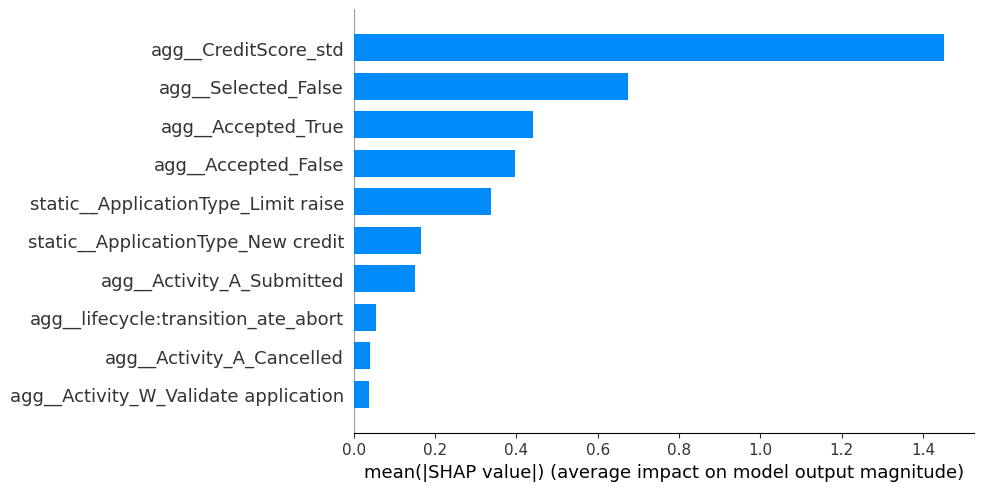

In [313]:
plt.grid(False)
shap_values = shap.TreeExplainer(cls).shap_values(dt_train_named[columns])
shap.summary_plot(shap_values, dt_train_named, plot_type="bar", max_display=10)
plt.show()

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(dt_train_named.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(10)

In [ ]:
cols = list(feature_importance['col_name'][0:10])

In [ ]:
cols

In [ ]:
for i in cols:
    print(i)

In [ ]:
plt.grid(False)
shap.summary_plot(shap_values, dt_train_named[columns])

In [ ]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
   
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    plt.grid(False)
ABS_SHAP(shap_values,dt_train_named[columns]) 

In [86]:
model = cls

In [87]:
# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [107]:
random_picks = np.arange(1,330,20) # Every 50 rows
S = dt_train_named.iloc[random_picks]
S

,static__ApplicationType_Limit raise,static__ApplicationType_New credit,agg__Activity_A_Cancelled,agg__Activity_A_Submitted,agg__Activity_W_Validate application,agg__lifecycle:transition_ate_abort,agg__Accepted_False,agg__Accepted_True,agg__Selected_False,agg__CreditScore_std
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000
21,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,391.700793
41,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.000000
61,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.000000
81,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,392.908039
101,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,237.868311
121,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,459.831285
141,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,414.517564
161,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
181,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.000000


In [108]:
shap.initjs()

In [112]:
shap_plot()

### Parsimony

#### LLM

In [191]:
len(dt_train_named_original[columns].columns)

10

In [192]:
p1 = (10-orig_coef_2[0].tolist().count(0))

In [193]:
p2 = (10-orig_coef_3[0].tolist().count(0))

In [194]:
p3 = (10-orig_coef_5[0].tolist().count(0))

In [195]:
p4 = (10-orig_coef_6[0].tolist().count(0))

In [196]:
(p1+p2+p3+p4)/4

9.0

In [197]:
(p1+p2+p3+p4)*259/4

2331.0

#### GLRM

In [175]:
for i in cls.explain()['rule']:
    print(i)

(intercept)
agg__Selected_False <= 0.00
agg__CreditScore_std <= 0.00
agg__Accepted_False <= 0.00 AND agg__Selected_False <= 7.00
static__ApplicationType_New credit  
static__ApplicationType_Limit raise  
agg__CreditScore_std <= 360.94
agg__Accepted_False <= 0.00
agg__Activity_A_Submitted  


#### XGB

In [301]:
cls.feature_importances_

array([0.19034322, 0.18436857, 0.14846894, 0.02729335, 0.01167782,
       0.03425556, 0.02664496, 0.0679672 , 0.21208249, 0.09689794],
      dtype=float32)

In [ ]:
df_shap = shap_values
df = dt_train_named[columns]

shap_v = pd.DataFrame(df_shap)
feature_list = df.columns
shap_v.columns = feature_list
df_v = df.copy().reset_index().drop('index',axis=1)
    

# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']

par = 0
for i in range(0,len(k)):
    if k['SHAP_abs'][i]>0:
        par = par+1

par

len(dt_train_named.columns)

259-223

223/259

### FC

#### LLM 

In [226]:
def functional_complexity(test_data, n_instances):

    result = test_data.copy()
    result2 = result.copy()
    list_of_sets=[]
    set_of_values = set()
    NF = 0
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list
    for i in range(0,len(result2.columns)):
        set_of_values = set(result2.iloc[:,i])
        list_of_sets.append(set_of_values)
    

    for j in range(0,len(result2.columns)):
        if len(list_of_sets[j]) <2:
            continue
        else:
            for i in range(0,n_instances):
                new_set = list_of_sets[j].copy()
                new_set.remove(result2.iloc[i,j])
                new_value = random.choice(list(new_set))
                result2.iloc[i,j] = new_value
                pred1 = logreg.predict(pd.DataFrame(result.iloc[:]))
                pred2 = logreg.predict(pd.DataFrame(result2.iloc[:]))
                if pred1[i] != pred2[i]:
                    NF = NF+1       
    return NF/(n_instances)

In [231]:
functional_complexity(dt_test_named_original[columns], 500)

1.082

In [232]:
1.066/11

0.09690909090909092

#### GLRM

In [2]:
def functional_complexity(test_data, n_instances):

    result = test_data.copy()
    result2 = result.copy()
    list_of_sets=[]
    set_of_values = set()
    NF = 0
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list
    for i in range(0,len(result2.columns)):
        set_of_values = set(result2.iloc[:,i])
        list_of_sets.append(set_of_values)
    

    for j in range(0,len(result2.columns)):
        if len(list_of_sets[j]) <2:
            continue
        else:
            for i in range(0,n_instances):
                new_set = list_of_sets[j].copy()
                new_set.remove(result2.iloc[i,j])
                new_value = random.choice(list(new_set))
                result2.iloc[i,j] = new_value
                x_1 = pd.DataFrame(result2.iloc[:])
               # print(x_1)
                x_1, x_1_std = fb.transform(pd.DataFrame(result.iloc[j][:]).T)
                x_2, x_2_std = fb.transform(pd.DataFrame(result.iloc[j][:]).T)
                pred1 = cls_glrm.predict(x_1)
                pred2 = cls_glrm.predict(x_2)
                if pred1 == pred2:
                    NF +=1 
    NF_total = NF/(len(x_1.columns)*n_instances)

    
    return NF_total

In [ ]:
functional_complexity(dt_test_named_original[columns],500)

In [274]:
0.38461538461538464/7

0.05494505494505495

In [188]:
dt_test_named_original[columns]

,static__ApplicationType_Limit raise,static__ApplicationType_New credit,agg__Activity_A_Cancelled,agg__Activity_A_Submitted,agg__Activity_W_Validate application,agg__lifecycle:transition_ate_abort,agg__Accepted_False,agg__Accepted_True,agg__Selected_False,agg__CreditScore_std
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,521.689563
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,544.886977
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,556.122943
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,560.384483
...,...,...,...,...,...,...,...,...,...,...
124810,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
124811,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
124812,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
124813,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [11]:
list1= [1,1]
list2 = [0,1]

In [12]:
import numpy as np

In [13]:
effect = (((np.array(list1) - np.array(list2)) ** 2)/2).sum() ** 0.5

In [14]:
effect

0.7071067811865476

#### XGB

In [304]:
def functional_complexity(test_data, n_instances):

    result = test_data.copy()
    result2 = result.copy()
    list_of_sets=[]
    set_of_values = set()
    NF = 0
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list
    for i in range(0,len(result2.columns)):
        set_of_values = set(result2.iloc[:,i])
        list_of_sets.append(set_of_values)
    

    for j in range(0,len(result2.columns)):
        if len(list_of_sets[j]) <2:
            continue
        else:
            for i in range(0,n_instances):
                new_set = list_of_sets[j].copy()
                new_set.remove(result2.iloc[i,j])
                new_value = random.choice(list(new_set))
                result2.iloc[i,j] = new_value
                pred1 = cls.predict(pd.DataFrame(result.iloc[i][:]).T)
                pred2 = cls.predict(pd.DataFrame(result2.iloc[i][:]).T)
                if pred1 != pred2:
                    NF = NF+1       
    return NF/(n_instances)

In [305]:
functional_complexity(dt_test_named, 500)

2.476

In [306]:
2.476/10

0.2476

### Monotonicity

In [308]:
#XGB feature importance

feature_importance_xgb=pd.DataFrame()
feature_importance_xgb['columns']=dt_train_named_original[columns].columns
feature_importance_xgb['importances_xgb'] = cls.feature_importances_
#feature_importance_xgb.sort_values(by='importances_xgb',ascending=False,inplace=True)
#feature_importance_xgb[:10]

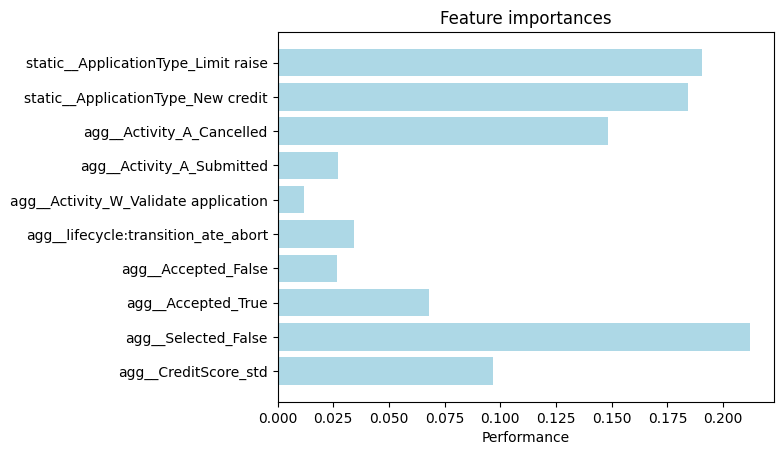

In [311]:
height = list(feature_importance_xgb['columns'][:10])
bars = list(feature_importance_xgb['importances_xgb'][:10])

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(height))
performance = bars

ax.barh(y_pos, performance, align='center',color='lightblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(height)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Feature importances')

plt.show()

In [ ]:
#shap value feature importance

res = [sum(x) / len(x) for x in zip(*abs(shap_values))]

In [315]:
shap_importances=pd.DataFrame()
shap_importances['columns']=dt_train_named_original[columns].columns
shap_importances['importances_shap'] = res



resulting_frame = pd.concat([shap_importances, feature_importance_xgb], join='inner', axis=1)

resulting_frame.sort_values(by='importances_xgb',ascending=False,inplace=True)
resulting_frame[:10]

,columns,importances_shap,columns,importances_xgb
8,agg__Selected_False,0.674460,agg__Selected_False,0.212082
0,static__ApplicationType_Limit raise,0.337261,static__ApplicationType_Limit raise,0.190343
1,static__ApplicationType_New credit,0.165472,static__ApplicationType_New credit,0.184369
2,agg__Activity_A_Cancelled,0.040745,agg__Activity_A_Cancelled,0.148469
9,agg__CreditScore_std,1.452116,agg__CreditScore_std,0.096898
7,agg__Accepted_True,0.438838,agg__Accepted_True,0.067967
5,agg__lifecycle:transition_ate_abort,0.054888,agg__lifecycle:transition_ate_abort,0.034256
3,agg__Activity_A_Submitted,0.149764,agg__Activity_A_Submitted,0.027293
6,agg__Accepted_False,0.397387,agg__Accepted_False,0.026645
4,agg__Activity_W_Validate application,0.036886,agg__Activity_W_Validate application,0.011678


In [317]:
from scipy.stats import kendalltau

coef, p = kendalltau(resulting_frame['importances_shap'], resulting_frame['importances_xgb'])
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)



Kendall correlation coefficient: 0.333
Samples are uncorrelated (fail to reject H0) p=0.216


In [318]:
from scipy.stats import spearmanr
# seed random number generator

# prepare data

coef, p = spearmanr(resulting_frame['importances_shap'], resulting_frame['importances_xgb'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.418
Samples are uncorrelated (fail to reject H0) p=0.229


In [ ]:
plt.grid(False)
#shap_values = shap.TreeExplainer(cls_xgb).shap_values(dt_train_named)
shap.summary_plot(shap_values, dt_train_named, plot_type="bar", max_display=10, color=['lightblue','red','lightblue','lightblue','red','red','lightblue','lightblue','lightblue','lightblue']
)
ax.set(facecolor = "orange")
plt.show()